In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
import joblib


In [2]:
# Charger le dataset
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
print(df.shape)

(7043, 21)


In [3]:
print(df.head())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [4]:
# Nettoyage des données
df = df.replace(" ", np.nan)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())

# Encodage des variables catégorielles
df_encoded = pd.get_dummies(df, drop_first=True)


In [5]:
print(df["Churn"].value_counts(normalize=True))

Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


In [6]:
# Séparation features/cible
X = df_encoded.drop("Churn_Yes", axis=1)
y = df_encoded["Churn_Yes"]

# Split en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


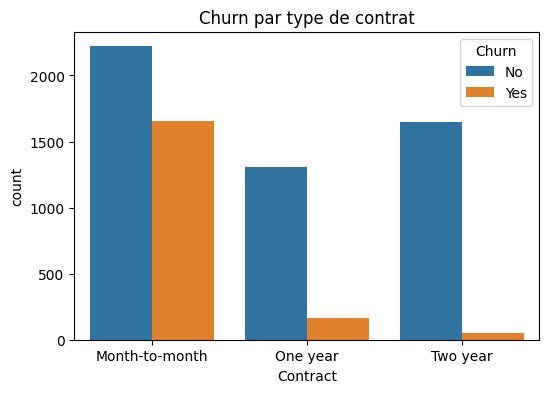

In [7]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Contract", hue="Churn")
plt.title("Churn par type de contrat")
plt.show()

In [8]:
# Imputer les valeurs manquantes
imputer = SimpleImputer(strategy='median')
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
# Sauvegarder les noms de colonnes pour l'app Streamlit
model_columns = X_train.columns.tolist()
joblib.dump(model_columns, "model_columns.pkl")

# Entraîner XGBoost
xgb_model = XGBClassifier(eval_metric="logloss", random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Évaluation du modèle
y_pred_xgb = xgb_model.predict(X_test_scaled)
print("XGBoost")
print(classification_report(y_test, y_pred_xgb))

XGBoost
              precision    recall  f1-score   support

       False       0.84      0.88      0.86      1035
        True       0.61      0.53      0.57       374

    accuracy                           0.78      1409
   macro avg       0.72      0.71      0.71      1409
weighted avg       0.78      0.78      0.78      1409



In [10]:
# Sauvegarder le modèle et les outils de preprocessing
joblib.dump(xgb_model, "xgb_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(imputer, "imputer.pkl")


['imputer.pkl']